# Getting Started
In this post, we'll demonstrate some of the core functionality of the **SDMetrics** library by using it to evaluate a synthetic dataset.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Generating Synthetic Datasets
The **SDV** library provides tools for generating synthetic relational databases. Let's start by loading the Walmart dataset and generating a synthetic copy with 20 rows in the root table.

In [2]:
from sdv import load_demo

metadata, real_tables = load_demo("walmart", metadata=True)
for table_name, df in real_tables.items():
    print(">", table_name)
    print(df.head().to_string(index=False))
    print()

> stores
 Store Type    Size
     1    A  151315
     2    A  202307
     3    B   37392
     4    A  205863
     5    B   34875

> features
 Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday
     1 2010-02-05        42.31       2.572        NaN        NaN        NaN        NaN        NaN  211.096358         8.106      False
     1 2010-02-12        38.51       2.548        NaN        NaN        NaN        NaN        NaN  211.242170         8.106       True
     1 2010-02-19        39.93       2.514        NaN        NaN        NaN        NaN        NaN  211.289143         8.106      False
     1 2010-02-26        46.63       2.561        NaN        NaN        NaN        NaN        NaN  211.319643         8.106      False
     1 2010-03-05        46.50       2.625        NaN        NaN        NaN        NaN        NaN  211.350143         8.106      False

> depts
 Store  Dept       Date  Weekly_Sales  I

In [3]:
from sdv import SDV

sdv = SDV()
sdv.fit(metadata, real_tables)

synthetic_tables = sdv.sample_all(100)
for table_name, df in synthetic_tables.items():
    print(">", table_name)
    print(df.head().to_string(index=False))
    print()

> stores
Type    Size  Store
   A  158863      0
   A  148881      1
   A  141181      2
   B   39402      3
   A  184711      4

> features
      Date     MarkDown1  Store  IsHoliday    MarkDown4    MarkDown3  Fuel_Price  Unemployment  Temperature    MarkDown5     MarkDown2         CPI
2011-02-02  14400.357649      0      False  2640.453224  2443.106190    3.550959      6.253251    76.279741          NaN  10794.829869  193.555658
2010-06-28   1992.568051      0      False          NaN          NaN    3.352604      4.566446    44.368874  1399.856071           NaN  173.742572
2011-11-20  15145.367881      0      False  1946.317167  3950.841584    3.539616      5.883201    72.896482          NaN  10712.726537  196.000664
2011-03-14           NaN      0      False          NaN          NaN    4.352685      4.818791    72.563082  5790.683617           NaN  182.003539
2012-02-05   7106.857092      0      False          NaN          NaN    3.638750      5.102400    46.585475  3104.993430    

## Evaluation with SDMetrics
Now that we have (1) a metadata object, (2) a set of real tables, and (3) a set of fake tables, we can pass them to **SDMetrics** for evaluation. The simplest way to get started with **SDMetrics** is to use the `evaluate` function which generates a report with the default metrics.

In [4]:
from sdmetrics import evaluate
report = evaluate(metadata, real_tables, synthetic_tables)
report

The metrics report can provide an **overall score**. This is a single scalar value which you can pass to an optimization routine (i.e. to tune some hyperparameters in your model).

In [5]:
print(report.overall())

-52.87242536803069


Furthermore, the metrics report can also provide some key highlights. This shows the problem areas where your model performs especially poorly - for example, the below highlights suggest that our model is very bad at modeling the `MarkDownX` columns since the kstest has detected that the distributions look quite different between the real and synthetic versions.

In [6]:
report.highlights()

,Name,Value,Goal,Unit,Tables,Columns,Misc. Tags
0,kstest,5.037590e-24,Goal.MAXIMIZE,p-value,table:features,column:MarkDown1,"statistic:univariate,priority:high"
1,kstest,2.999024e-37,Goal.MAXIMIZE,p-value,table:features,column:MarkDown4,"statistic:univariate,priority:high"
2,kstest,3.759181e-190,Goal.MAXIMIZE,p-value,table:features,column:MarkDown3,"statistic:univariate,priority:high"
3,kstest,3.072000e-79,Goal.MAXIMIZE,p-value,table:features,column:Fuel_Price,"statistic:univariate,priority:high"
4,kstest,1.294061e-32,Goal.MAXIMIZE,p-value,table:features,column:Unemployment,"statistic:univariate,priority:high"
5,kstest,1.148167e-09,Goal.MAXIMIZE,p-value,table:features,column:Temperature,"statistic:univariate,priority:high"
6,kstest,5.218656e-16,Goal.MAXIMIZE,p-value,table:features,column:MarkDown5,"statistic:univariate,priority:high"
7,kstest,1.564043e-87,Goal.MAXIMIZE,p-value,table:features,column:MarkDown2,"statistic:univariate,priority:high"
8,kstest,0.000000e+00,Goal.MAXIMIZE,p-value,table:features,column:CPI,"statistic:univariate,priority:high"
9,kstest,0.000000e+00,Goal.MAXIMIZE,p-value,table:depts,column:Weekly_Sales,"statistic:univariate,priority:high"


In addition, you will also be able to generate a visualization of the metrics.

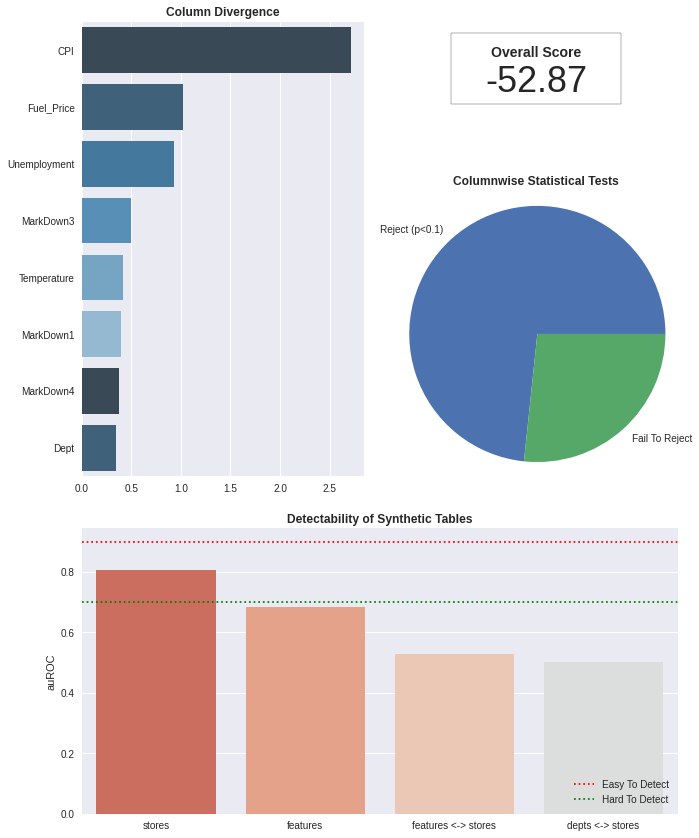

In [7]:
report.visualize();

Finally, you can also print a detailed report containing all of the metrics that were computed.

In [8]:
report.details()

,Name,Value,Goal,Unit,Tables,Columns,Misc. Tags
0,foreign-key,1.000000,Goal.MAXIMIZE,binary,table:stores,,child:features
1,foreign-key,1.000000,Goal.MAXIMIZE,binary,table:stores,,child:depts
2,logistic,0.536250,Goal.MINIMIZE,auroc,table:features,,detection:auroc
3,logistic,0.609923,Goal.MINIMIZE,auroc,table:stores,,detection:auroc
4,logistic,0.516956,Goal.MINIMIZE,auroc,table:depts,,detection:auroc
...,...,...,...,...,...,...,...
90,continuous-kl,5.439273,Goal.MINIMIZE,entropy,table:features,"column:CPI,column:Unemployment",statistic:bivariate
91,continuous-kl,1.993923,Goal.MINIMIZE,entropy,table:features,"column:CPI,column:Temperature",statistic:bivariate
92,continuous-kl,1.417703,Goal.MINIMIZE,entropy,table:features,"column:CPI,column:MarkDown5",statistic:bivariate
93,continuous-kl,1.668086,Goal.MINIMIZE,entropy,table:features,"column:CPI,column:MarkDown2",statistic:bivariate
